In [1]:
import json
import re
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import requests
import re

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

In [2]:
NEWS_WORK_DIR = './newsmodels'
WORKING_DIR = './finetuning'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels = json.load(open('imagenet_class_index.json'))
f = open(NEWS_WORK_DIR+'/ner_for_classes.json')
ner_dict = json.load(f)
f.close()

## Step 1: Generate caption template for an image

In [4]:
model_news = load_model(NEWS_WORK_DIR+'/newstwentyepochs.h5')
model_finetune = load_model(WORKING_DIR+'/finetuningfifteen_mix.h5')

In [5]:
with open(WORKING_DIR+'/tokenizer_mix.json') as f:
    tokenizer_mix = tokenizer_from_json(json.load(f))
with open(NEWS_WORK_DIR+'/tokenizer.json') as f:
    tokenizer_news = tokenizer_from_json(json.load(f))

In [6]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [71]:
def generate_caption_template(image,model,tokenizer,max_length):
    image_model = VGG16()
    image_model = Model(inputs=image_model.inputs, outputs=image_model.layers[-2].output)
    feature = image_model.predict(image, verbose=0)
    y_pred = predict_caption(model, feature, tokenizer, max_length)
    y_pred = y_pred.replace(' person ',' <person> ')
    y_pred = y_pred.replace(' norp ',' <norp> ')
    y_pred = y_pred.replace(' fac ',' <fac> ')
    y_pred = y_pred.replace(' org ',' <org> ')
    y_pred = y_pred.replace(' gpe ',' <gpe> ')
    y_pred = y_pred.replace(' loc ',' <loc> ')
    y_pred = y_pred.replace(' product ',' <product> ')
    y_pred = y_pred.replace(' event ',' <event> ')
    y_pred = y_pred.replace(' work of art ',' <work_of_art> ')
    y_pred = y_pred.replace(' law ' ,' <law> ')
    y_pred = y_pred.replace(' language ',' <language> ')
    y_pred = y_pred.replace(' date ',' <date> ')
    y_pred = y_pred.replace(' time ',' <time> ')
    y_pred = y_pred.replace(' percent ',' <percent> ')
    y_pred = y_pred.replace(' money ',' <money> ')
    y_pred = y_pred.replace(' quantity ',' <quantity> ')
    y_pred = y_pred.replace(' ordinal ',' <ordinal> ')
    y_pred = y_pred.replace(' cardinal ',' <cardinal> ')
    y_pred = y_pred.replace('startseq ','')
    y_pred = y_pred.replace(' endseq','')
    print('--------------------Predicted--------------------')
    print(y_pred)
    return y_pred

## Step 2 : Classifty input image

In [8]:
def classify_one_image_with_prob(image):
    torch.manual_seed(42)
    model = models.vgg16(weights='IMAGENET1K_V1')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
    image = transform(image).unsqueeze(0).to(device)  
    prediction = model(image)
    prob = torch.nn.functional.softmax(prediction, dim=1)[0].detach().numpy()
    top3_idx = prob.argsort()[-3:]
    class_labels = []
    class_probs = []
    for i in top3_idx:
        class_prob = prob[i]
        if class_prob>0.1: # Only consider classes with probability greater than 0.1
            class_label = labels[str(i)][1]
            class_labels.append(class_label)
            class_probs.append(class_prob)
    if len(class_labels)==0:
        class_prob = prob[top3_idx[-1]]
        class_probs.append(class_prob)
        class_label = labels[str(top3_idx[-1])][1]
        class_labels.append(class_label)
    print("Predicted image classes: ",class_labels)
    print("Predicted image class probabilities: ",class_probs)
    return class_labels,class_probs

## Step 3: Fill in caption template with named entities from the classifed image class 

In [9]:
def fill_caption_template(template,image_class,image_prob,ner_dict):
    class_selected = np.random.choice(image_class,p=image_prob/(np.sum(image_prob)))
    ner_dict_class = ner_dict[class_selected]
    ner_regex = re.compile(r'<[a-z_]+>')
    matched_indices = [x.span() for x in re.finditer(ner_regex, template)]
    new_caption = template
    for indices in matched_indices:
        start_idx = indices[0]
        end_idx = indices[1]
        ne = template[(start_idx+1):(end_idx-1)]
        ne_candidates = ner_dict_class[ne.upper()]
        ne_selected = np.random.choice(ne_candidates)
        ne_selected = re.sub('\n+', '',ne_selected)
        new_caption = new_caption.replace('<'+ne+'>',ne_selected,1)
    print('--------------------News caption generated--------------------')
    print(new_caption)

## Demo

In [10]:
def generate_news_caption(image_url,model,tokenizer,ner_dict,max_length):
    raw_image = Image.open(requests.get(image_url, stream=True).raw).resize((224,224)).convert('RGB') 
    display(raw_image)
    image = img_to_array(raw_image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    caption_template = generate_caption_template(image,model,tokenizer,max_length)
    class_labels,class_probs = classify_one_image_with_prob(raw_image)
    fill_caption_template(caption_template,class_labels,class_probs,ner_dict)

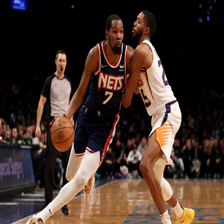

--------------------Predicted--------------------
<person> left and <person> yangchen fly of <org> in <date> breaking breaking the <ordinal> goal in <date>
Predicted image classes:  ['basketball']
Predicted image class probabilities:  [0.9904275]
--------------------News caption generated--------------------
Maier left and D'Antoni yangchen fly of Bosh in Wednesday breaking breaking the 34th goal in Just this past weekend


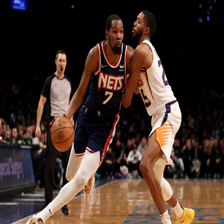

--------------------Predicted--------------------
<person> left and <person> in the <ordinal> round
Predicted image classes:  ['basketball']
Predicted image class probabilities:  [0.9904275]
--------------------News caption generated--------------------
Kemba Walker left and Jack in the first round


In [72]:
url = 'https://cdn.vox-cdn.com/thumbor/4-Ss3qYbc3oIDciTlgKBcjxDErQ=/0x0:3651x2773/1220x813/filters:focal(1549x629:2133x1213):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/71038971/1355926306.0.jpg'
generate_news_caption(url,model_news,tokenizer_news,ner_dict,107)
generate_news_caption(url,model_finetune,tokenizer_mix,ner_dict,107)

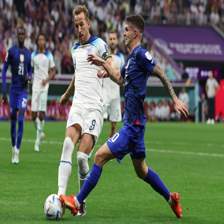

--------------------Predicted--------------------
<person> left and <person> in the final round on <date>
Predicted image classes:  ['rugby_ball', 'soccer_ball']
Predicted image class probabilities:  [0.32739288, 0.6284489]
--------------------News caption generated--------------------
Alvaro Negredo left and King in the final round on a weekend


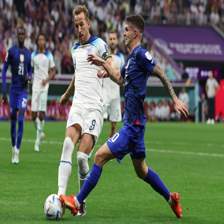

--------------------Predicted--------------------
<person> left and <person> in the <ordinal> round
Predicted image classes:  ['rugby_ball', 'soccer_ball']
Predicted image class probabilities:  [0.32739288, 0.6284489]
--------------------News caption generated--------------------
Angel Di Maria left and Johnson in the first round


In [34]:
url = 'https://www.aljazeera.com/wp-content/uploads/2022/11/2022-11-25T201859Z_1130363067_UP1EIBP1KFLMD_RTRMADP_3_SOCCER-WORLDCUP-ENG-USA-REPORT.jpg?resize=770%2C513'
generate_news_caption(url,model_news,tokenizer_news,ner_dict,107)
generate_news_caption(url,model_finetune,tokenizer_mix,ner_dict,107)

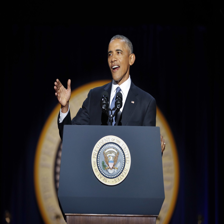

--------------------Predicted--------------------
the former <org> chief executive <person> at news conference in <gpe> on <date>
Predicted image classes:  ['French_horn', 'academic_gown']
Predicted image class probabilities:  [0.10656656, 0.37626943]
--------------------News caption generated--------------------
the former the Little Syria chief executive Gingrich at news conference in the United States on October


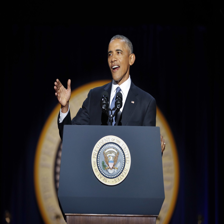

--------------------Predicted--------------------
<person> and <person> in the iceman directed by <person>
Predicted image classes:  ['French_horn', 'academic_gown']
Predicted image class probabilities:  [0.10656656, 0.37626943]
--------------------News caption generated--------------------
Julian Koster and Clark in the iceman directed by Bobby Flay


In [66]:
url = 'https://media-cldnry.s-nbcnews.com/image/upload/t_fit-1240w,f_auto,q_auto:best/newscms/2017_02/1861016/170110-obama-farewell-rhk.jpg'
generate_news_caption(url,model_news,tokenizer_news,ner_dict,107)
generate_news_caption(url,model_finetune,tokenizer_mix,ner_dict,107)

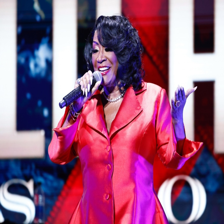

--------------------Predicted--------------------
<person> performing in <gpe> on <date>
Predicted image classes:  ['ocarina']
Predicted image class probabilities:  [0.08605006]
--------------------News caption generated--------------------
Korb performing in Williamsburg on Wednesday


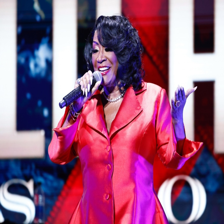

--------------------Predicted--------------------
<person> and <person> in the wiz in the wiz in <date>
Predicted image classes:  ['ocarina']
Predicted image class probabilities:  [0.08605006]
--------------------News caption generated--------------------
Brian Bedford and Robert Troilo in the wiz in the wiz in the early '80s


In [73]:
url = 'https://akns-images.eonline.com/eol_images/Entire_Site/2022112/rs_1024x759-221202142208-1024-patti-labelle-mv-12222.jpg?fit=around%7C1024:760&output-quality=90&crop=1024:760;center,top'
generate_news_caption(url,model_news,tokenizer_news,ner_dict,107)
generate_news_caption(url,model_finetune,tokenizer_mix,ner_dict,107)

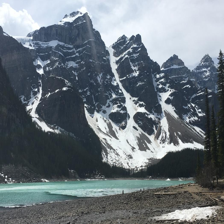

--------------------Predicted--------------------
the qori kalis glacier in <gpe>
Predicted image classes:  ['valley', 'alp']
Predicted image class probabilities:  [0.2326671, 0.6006406]
--------------------News caption generated--------------------
the qori kalis glacier in Sylvicola


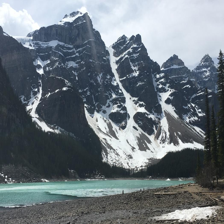

--------------------Predicted--------------------
an injured man was in <date> in <date>
Predicted image classes:  ['valley', 'alp']
Predicted image class probabilities:  [0.2326671, 0.6006406]
--------------------News caption generated--------------------
an injured man was in the coming days in 2010


In [43]:
url = 'https://media.discordapp.net/attachments/1048005346993647619/1049101460551499837/mountain.JPG?width=1049&height=787'
generate_news_caption(url,model_news,tokenizer_news,ner_dict,107)
generate_news_caption(url,model_finetune,tokenizer_mix,ner_dict,107)

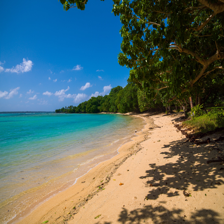

--------------------Predicted--------------------
the empty parking lot of the <org> chocolate flags in <gpe> in <date>
Predicted image classes:  ['sandbar', 'seashore']
Predicted image class probabilities:  [0.47567493, 0.5123025]
--------------------News caption generated--------------------
the empty parking lot of the Wayne Shorter Quartet chocolate flags in Moonee in monthly


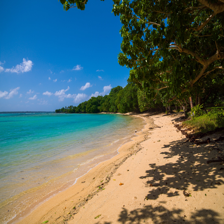

--------------------Predicted--------------------
<person> ohalloran the <ordinal> project which was unveiled on <date>
Predicted image classes:  ['sandbar', 'seashore']
Predicted image class probabilities:  [0.47567493, 0.5123025]
--------------------News caption generated--------------------
Keys ohalloran the second project which was unveiled on two days


In [74]:
url = 'https://media.architecturaldigest.com/photos/5af4aed394fddd48f4c4ce73/master/w_2580%2Cc_limit/2%2520Champagne%2520Beach.jpg'
generate_news_caption(url,model_news,tokenizer_news,ner_dict,107)
generate_news_caption(url,model_finetune,tokenizer_mix,ner_dict,107)

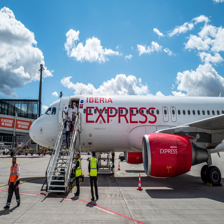

--------------------Predicted--------------------
the graves for the graves in the waterfront in <gpe>
Predicted image classes:  ['wing', 'airliner']
Predicted image class probabilities:  [0.11587425, 0.83068305]
--------------------News caption generated--------------------
the graves for the graves in the waterfront in Los Angeles


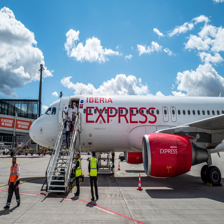

--------------------Predicted--------------------
the <org> majority leader <person> in <date> in <date>
Predicted image classes:  ['wing', 'airliner']
Predicted image class probabilities:  [0.11587425, 0.83068305]
--------------------News caption generated--------------------
the the Public Transport majority leader Thompson in recent years in the past month


In [69]:
url = 'https://i.insider.com/6322efd7e555ad001852bc91?width=1300&format=jpeg&auto=webp'
generate_news_caption(url,model_news,tokenizer_news,ner_dict,107)
generate_news_caption(url,model_finetune,tokenizer_mix,ner_dict,107)